# Trenches on CNN-Ensemble

In [3]:
%cd ../gendist/experiments
%load_ext autoreload
%autoreload 2

/home/gerardoduran/documents/shift-happens/gendist/experiments


In [4]:
import re
import os
import jax
import optax
import gendist
import pickle
import torchvision
import jax.numpy as jnp
import numpy as np
import mnist_rotation_meta as metaexp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree

In [5]:
import os
from loguru import logger
from datetime import datetime

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
%config InlineBackend.figure_format = "retina"

In [8]:
ls ../../outputs/cnn-rotation/output

cnn-00.pkl  cnn-02.pkl  cnn-04.pkl  cnn-06.pkl  cnn-08.pkl
cnn-01.pkl  cnn-03.pkl  cnn-05.pkl  cnn-07.pkl  cnn-09.pkl


In [9]:
path_experiment = os.path.join("..", "..", "outputs", "cnn-rotation")
filename_data_model = os.path.join(path_experiment, "output", "cnn-00.pkl")
filename_meta_model = os.path.join(path_experiment, "output", "meta-model-result.pkl")

In [10]:
output = metaexp.load_train_combo(filename_data_model)
target_params_single = output["params"]

In [11]:
path_outputs = os.path.join(path_experiment, "output")
files_model = sorted(os.listdir(path_outputs))
target_params = jnp.zeros((len(files_model), *target_params_single.shape))
target_params.shape

(10, 150, 61706)

In [12]:
for i, file in enumerate(files_model):
    path_file = os.path.join(path_outputs, file)
    output = metaexp.load_train_combo(path_file)
    target_params_single = output["params"]
    target_params = target_params.at[i, ...].set(target_params_single)
fn_reconstruct_params = output["fn_reconstruct"]

In [13]:
list_configs = output["configs"]
configs = jnp.array([v["angle"] for v in list_configs])
configs_all = configs * jnp.ones((10, 1))
configs_all = configs_all.ravel()

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


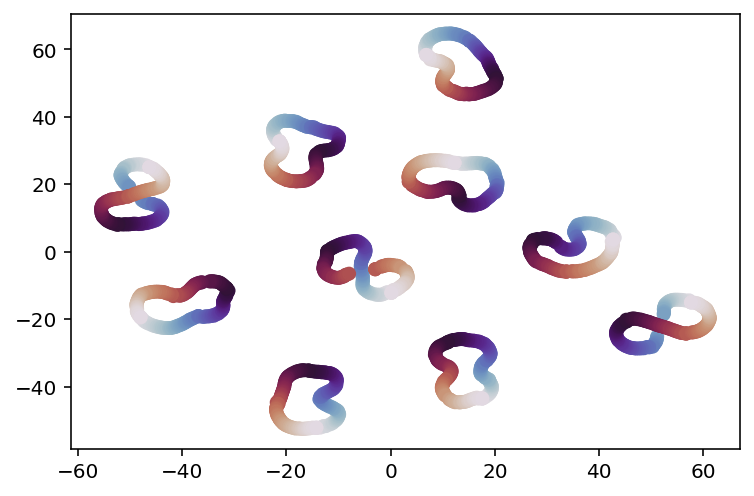

In [14]:
n_components = 2
tsnse = TSNE(n_components=n_components, init="pca", learning_rate="auto", random_state=314)
projected_params = tsnse.fit_transform(target_params.reshape(1500, -1))

plt.scatter(*projected_params.T, c=configs_all, cmap="twilight")

## PCA projection

In [56]:
n_components = 50
pca = PCA(n_components)
projected_params = pca.fit_transform(target_params.reshape(1500, -1))
projected_params = projected_params.reshape(10, 150, -1)

In [39]:
n_classes = 10
n_train_subset = 6_000
n_configs = len(configs)

In [27]:
key = jax.random.PRNGKey(314)
key, key_subset = jax.random.split(key)
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
X_train = np.array(mnist_train.data) / 255
X_train = metaexp.configure_covariates(key_subset, metaexp.processing_class, X_train, list_configs, n_train_subset)

n_train, *elem_dims = X_train.shape

tcmalloc: large alloc 5644804096 bytes == 0x55782e1ea000 @  0x7f1f0ff43680 0x7f1f0ff64824 0x7f1eee68f1ed 0x7f1eee68f267 0x7f1eee6d1c1b 0x7f1eee6d1ed8 0x7f1eee783177 0x7f1eee784dec 0x7f1eee8ca652 0x55773c9d1e88 0x55773cb535d8 0x7f1eee78bff7 0x55773cabf520 0x55773cafa568 0x55773cab48c3 0x55773ca2c1ca 0x55773cab3b32 0x55773cb63ddc 0x55773cab4b5b 0x55773cb998fe 0x55773ca92581 0x55773ca2c3be 0x55773caa4d34 0x55773cafe3ff 0x55773caa4d34 0x55773cafe3ff 0x55773caa4d34 0x55773caae0a3 0x55773ca2c1a4 0x55773cab48c3 0x55773ca2c3be
tcmalloc: large alloc 2822406144 bytes == 0x557a0b622000 @  0x7f1f0ff43680 0x7f1f0ff64824 0x7f1eee68f1ed 0x7f1eee68f267 0x7f1eee6d1c1b 0x7f1eee76eb5e 0x7f1eee76f37a 0x7f1eee76f5ae 0x55773ca73e64 0x55773ca6d7e4 0x7f1eee6bea74 0x55773ca73e88 0x55773ca6de4f 0x55773caf9937 0x55773cab3b32 0x55773cab4697 0x55773ca2bf00 0x55773cab48c3 0x55773ca2c1a4 0x55773cab3b32 0x55773cab4697 0x55773caa460a 0x55773caa49d5 0x55773ca6de4f 0x55773caf9937 0x55773cab48c3 0x55773ca2c1ca 0x55773cab

In [41]:
alpha = 0.0005
n_epochs = 200
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

meta_output = trainer.fit(key, X_train, projected_params, n_epochs, batch_size)

  0%|          | 0/200 [00:00<?, ?it/s]

In [44]:
meta_output.keys()

dict_keys(['params', 'losses'])

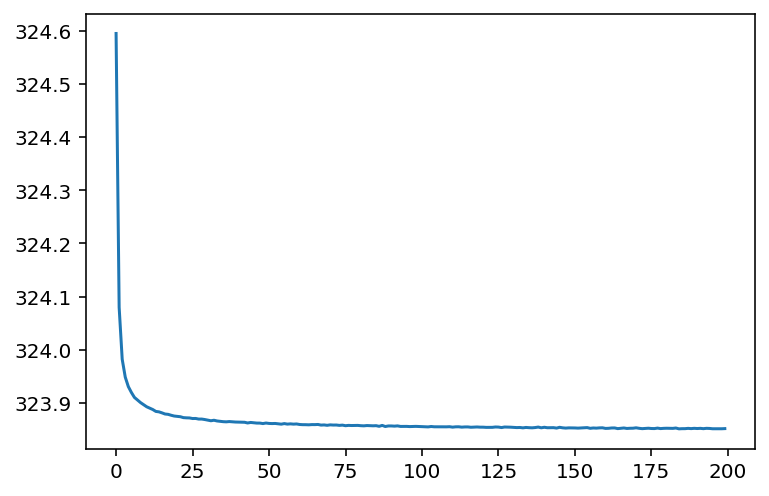

In [45]:
plt.plot(meta_output["losses"])

In [51]:
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

## Testing the model

In [65]:
def test_meta_model(ixs, X_test, fn_processing, configurations, meta_model,
                    data_model, meta_model_params, fn_reconstruct, projector,
                    logger):
    acc_configs_learned = []
    for config in configurations:
        acc_dict = {}
        for ix in ixs:
            yhat_test = metaexp.predict_shifted_dataset(ix, X_test, fn_processing, config,
                                                        meta_model, meta_model_params,
                                                        data_model, projector, fn_reconstruct)
            yhat_test = yhat_test.argmax(axis=1)
            accuracy_learned = (yhat_test == y_test).mean().item()
            acc_dict[ix] = accuracy_learned
        acc_configs_learned.append(acc_dict)
        
        angle = config["angle"]
        logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
        logger_row = f"{angle=:0.4f} | " + logger_row 

        logger.info(logger_row)
    
    return pd.DataFrame(acc_configs_learned)


In [49]:
logger.remove()
now_str = datetime.now().strftime("%Y%m%d%H%M")
# file_log = f"trench_test_{now_str}.log"
file_log = "cnn-test-full.log"

path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")
print(file_log)

cnn-test-full.log


In [68]:
data_model = gendist.models.LeNet5(10)

## Autoencoder

Model taken from [Flax's main page on Github](https://github.com/google/flax).

In [18]:
import flax.linen as nn
from typing import Sequence

class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class AutoEncoder(nn.Module):
  encoder_widths: Sequence[int]
  decoder_widths: Sequence[int]
  input_shape: Sequence[int]

  def setup(self):
    input_dim = np.prod(self.input_shape)
    self.encoder = MLP(self.encoder_widths)
    self.decoder = MLP(self.decoder_widths + (input_dim,))

  def __call__(self, x):
    return self.decode(self.encode(x))

  def encode(self, x):
    assert x.shape[1:] == self.input_shape
    return self.encoder(jnp.reshape(x, (x.shape[0], -1)))

  def decode(self, z):
    z = self.decoder(z)
    x = nn.sigmoid(z)
    x = jnp.reshape(x, (x.shape[0],) + self.input_shape)
    return 

In [22]:
*_, n_full = target_params.shape

In [21]:
n_full

61706

In [73]:
model = AutoEncoder(encoder_widths=[100, 50],
                    decoder_widths=[50, 100],
                    input_shape=(n_full,))

key = jax.random.PRNGKey(271)
batch = jnp.ones((1, n_full))
proj_params = model.init(key, batch)

format(len(ravel_pytree(proj_params)[0]), ",")

'12,415,706'